In [8]:
import os
import sys
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

# --- Path Setup ---
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

from config import CONFIG

# --- Directories ---
# IMPORTANT: We now take input from Step 04 (Filtering)
DERIV_FILTERED = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_04_filtering")
DERIV_REF = os.path.join(PROJECT_ROOT, CONFIG['derivatives_dir'], "step_05_reference") # Renumbered to 05 or kept as 04
QC_REF = os.path.join(PROJECT_ROOT, CONFIG['qc_dir'], "step_05_reference")

os.makedirs(DERIV_REF, exist_ok=True)
os.makedirs(QC_REF, exist_ok=True)

# Derive filename from config (synchronized with previous notebooks)
csv_filename = Path(CONFIG['current_csv']).stem
RUN_ID = csv_filename
INPUT_FILE = Path(DERIV_FILTERED) / f"{RUN_ID}__filtered.parquet"

if not INPUT_FILE.exists():
    raise FileNotFoundError(f"Expected file not found: {INPUT_FILE}. Did you run notebook 04?")

df = pd.read_parquet(INPUT_FILE)
print(f"Loaded Filtered Data for Reference Detection: {RUN_ID}")

Loaded Filtered Data for Reference Detection: 763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005


In [9]:
def find_optimal_reference_window(df, search_limit_sec=10.0, window_sec=1.5):
    """
    Scans for the most stable T-Pose. Automatically detects mm vs meters.
    """
    fs = CONFIG.get('fs_target', 120.0)
    search_frames = int(search_limit_sec * fs)
    window_frames = int(window_sec * fs)
    
    # Identify columns
    hips_p_cols = [c for c in df.columns if 'Hips__p' in c]
    hips_q_cols = [c for c in df.columns if 'Hips__q' in c]
    l_hand_cols = [c for c in df.columns if any(x in c for x in ['L_Hand__p', 'LeftHand__p'])]
    r_hand_cols = [c for c in df.columns if any(x in c for x in ['R_Hand__p', 'RightHand__p'])]
    
    # --- Unit Detection ---
    # Detect if data is in mm (e.g., 285.0) or meters (e.g., 0.285)
    sample_val = abs(df[hips_p_cols[0]].iloc[0])
    IS_MM = sample_val > 10.0 
    UNIT_LABEL = "mm" if IS_MM else "m"
    T_POSE_THRESH = 800.0 if IS_MM else 0.8 # 80cm minimum span
    
    best_start_idx = 0
    min_score = float('inf')
    best_metrics = {}

    print(f"🔍 Unit Detection: Data appears to be in {UNIT_LABEL.upper()}")

    for start in range(0, min(len(df), search_frames) - window_frames, 5):
        win = df.iloc[start : start + window_frames]
        
        # 1. Linear Stability (Standard Deviation)
        pos_std = np.sqrt(win[hips_p_cols].var().mean()) 
        
        # 2. Angular Stability (Euler Variance)
        quats = win[hips_q_cols].values
        euler_angles = R.from_quat(quats).as_euler('xyz', degrees=True)
        ang_std = np.std(euler_angles, axis=0).mean()
        
        # 3. T-Pose & Symmetry Validation
        t_pose_penalty = 1.0
        hand_dist = 0.0
        sym_error = 0.0
        
        if l_hand_cols and r_hand_cols:
            l_mean = win[l_hand_cols].mean().values
            r_mean = win[r_hand_cols].mean().values
            h_mean = win[hips_p_cols].mean().values
            
            hand_dist = np.linalg.norm(l_mean - r_mean)
            dist_l = np.linalg.norm(l_mean - h_mean)
            dist_r = np.linalg.norm(r_mean - h_mean)
            sym_error = abs(dist_l - dist_r)
            
            # Penalize if arms are tucked or highly uneven
            if hand_dist < T_POSE_THRESH: t_pose_penalty += 20.0
            if sym_error > (150.0 if IS_MM else 0.15): t_pose_penalty += 5.0

        # Score normalization (Weights stability and posture)
        current_score = (pos_std + ang_std) * t_pose_penalty
        
        if current_score < min_score:
            min_score = current_score
            best_start_idx = start
            best_metrics = {
                "ref_stability_raw": float(pos_std),
                "ref_angular_std_deg": float(ang_std),
                "hand_dist_raw": float(hand_dist),
                "sym_error_raw": float(sym_error),
                "is_mm": IS_MM
            }
            
    res_win = df.iloc[best_start_idx : best_start_idx + window_frames]
    
    # Final conversion for display/reporting
    is_mm = best_metrics['is_mm']
    metrics = {
        "start_idx": best_start_idx,
        "ref_df": res_win,
        "stability_mm": best_metrics['ref_stability_raw'] if is_mm else best_metrics['ref_stability_raw']*1000,
        "angular_std_deg": best_metrics['ref_angular_std_deg'],
        "hand_dist_cm": (best_metrics['hand_dist_raw'] / 10) if is_mm else (best_metrics['hand_dist_raw'] * 100),
        "sym_error_cm": (best_metrics['sym_error_raw'] / 10) if is_mm else (best_metrics['sym_error_raw'] * 100),
    }
    
    # Reliability Grade
    if metrics['stability_mm'] < 2.5 and metrics['angular_std_deg'] < 1.0:
        metrics['grade'] = "HIGH"
    elif metrics['stability_mm'] < 6.0:
        metrics['grade'] = "MEDIUM"
    else:
        metrics['grade'] = "LOW"
        
    return metrics

# Run correctly scaled search
res = find_optimal_reference_window(df)
ref_results = res # Legacy compatibility

print(f"\n🎯 Reference Window: {res['start_idx']/120:.2f}s | Grade: {res['grade']}")
print(f"📊 Stability: {res['stability_mm']:.2f} mm | Angular: {res['angular_std_deg']:.2f}°")
print(f"📏 Span: {res['hand_dist_cm']:.1f} cm | Symmetry Error: {res['sym_error_cm']:.2f} cm")

🔍 Unit Detection: Data appears to be in MM

🎯 Reference Window: 2.04s | Grade: HIGH
📊 Stability: 1.79 mm | Angular: 0.07°
📏 Span: 99.0 cm | Symmetry Error: 2.29 cm


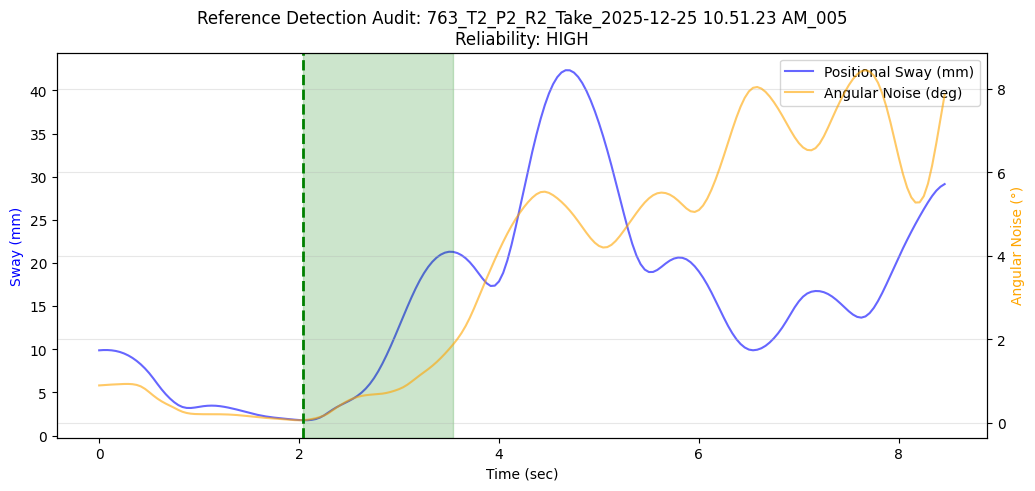

✅ Stability Audit Plot saved to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\qc\step_05_reference\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__stability_audit.png


In [10]:
def plot_reference_stability(df, search_limit_sec=10.0, window_sec=1.5):
    """
    Recalculates scores for plotting and generates a stability report graph.
    """
    fs = CONFIG.get('fs_target', 120.0)
    search_frames = int(search_limit_sec * fs)
    window_frames = int(window_sec * fs)
    
    # Setup columns
    hips_p_cols = [c for c in df.columns if 'Hips__p' in c]
    hips_q_cols = [c for c in df.columns if 'Hips__q' in c]
    
    times = []
    pos_scores = []
    ang_scores = []
    
    # Sampling for visualization
    for start in range(0, min(len(df), search_frames) - window_frames, 5):
        win = df.iloc[start : start + window_frames]
        
        # Calculate metrics
        pos_std = np.sqrt(win[hips_p_cols].var().mean()) 
        quats = win[hips_q_cols].values
        euler_angles = R.from_quat(quats).as_euler('xyz', degrees=True)
        ang_std = np.std(euler_angles, axis=0).mean()
        
        times.append(start / fs)
        pos_scores.append(pos_std)
        ang_scores.append(ang_std)

    # Plotting
    plt.figure(figsize=(12, 5))
    
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    lns1 = ax1.plot(times, pos_scores, color='blue', alpha=0.6, label='Positional Sway (mm)')
    lns2 = ax2.plot(times, ang_scores, color='orange', alpha=0.6, label='Angular Noise (deg)')
    
    # Mark the chosen window
    best_time = res['start_idx'] / fs
    plt.axvspan(best_time, best_time + window_sec, color='green', alpha=0.2, label='Selected Reference Window')
    plt.axvline(best_time, color='green', linestyle='--', linewidth=2)
    
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Sway (mm)', color='blue')
    ax2.set_ylabel('Angular Noise (°)', color='orange')
    
    plt.title(f"Reference Detection Audit: {RUN_ID}\nReliability: {res.get('grade', 'UNKNOWN')}")
    
    # Combine legends
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='upper right')
    
    plt.grid(True, alpha=0.3)
    
    # Save for QC
    qc_plot_path = os.path.join(QC_REF, f"{RUN_ID}__stability_audit.png")
    plt.savefig(qc_plot_path)
    plt.show()
    
    print(f"✅ Stability Audit Plot saved to: {qc_plot_path}")

# Run visualization
plot_reference_stability(df)

In [11]:
def extract_reference_rotations_v2(ref_df):
    """
    Extracts mean rotations for all bones. 
    Ensures Quaternions are normalized and provides Euler equivalent for debugging.
    """
    ref_map = {}
    euler_map = {}
    quat_cols = [c for c in ref_df.columns if '__q' in c]
    bones = set([c.split('__')[0] for c in quat_cols])
    
    for bone in bones:
        # Expected naming convention: Bone__qx, Bone__qy, Bone__qz, Bone__qw
        b_cols = [f"{bone}__q{s}" for s in ['x', 'y', 'z', 'w']]
        if all(c in ref_df.columns for c in b_cols):
            # Calculate mean and RE-NORMALIZE (Critical for quaternion validity)
            q_mean = ref_df[b_cols].mean().values
            norm = np.linalg.norm(q_mean)
            q_final = q_mean / norm if norm > 0 else np.array([0,0,0,1])
            
            for i, c in enumerate(b_cols):
                ref_map[c] = float(q_final[i])
            
            # Store Euler angles (degrees) for human-readable audit
            euler_map[bone] = R.from_quat(q_final).as_euler('xyz', degrees=True).tolist()
            
    return ref_map, euler_map

# Process and save
REFERENCE_ROTATIONS, REFERENCE_EULER = extract_reference_rotations_v2(res['ref_df'])

# Save primary map
map_path = os.path.join(DERIV_REF, f"{RUN_ID}__reference_map.json")
with open(map_path, 'w') as f:
    json.dump(REFERENCE_ROTATIONS, f, indent=4)

# Save secondary Euler audit file
euler_path = os.path.join(DERIV_REF, f"{RUN_ID}__reference_euler.json")
with open(euler_path, 'w') as f:
    json.dump(REFERENCE_EULER, f, indent=4)

print(f"✅ Reference Map & Euler Audit saved to: {DERIV_REF}")

✅ Reference Map & Euler Audit saved to: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_05_reference


In [12]:
# --- Cell 4: Enhanced Export for Master Audit Report ---

summary_path = os.path.join(DERIV_REF, f"{RUN_ID}__reference_summary.json")

summary_data = {
    "run_id": str(RUN_ID),
    "identity": {
        "timestamp": pd.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
        "version": "v2.0_multi_modal_stability"
    },
    "reliability_report": {
        "overall_grade": res.get('grade', 'UNKNOWN'),  # Fixed: was 'reliability_grade'
        "pos_stability_mm": round(res.get('stability_mm', 0), 3),  # Fixed: was 'ref_stability_mm'
        "ang_stability_deg": round(res.get('angular_std_deg', 0), 3),  # Fixed: was 'ref_angular_std_deg'
        "symmetry_error_cm": round(res.get('sym_error_cm', 0), 2),  # Fixed: was 'symmetry_error_m'*100
        "hand_dist_cm": round(res.get('hand_dist_cm', 0), 2),  # Added: span measurement
        "is_t_pose_valid": res.get('hand_dist_cm', 0) > 80.0  # Fixed: check if hands span > 80cm
    },
    "reference_metrics": {
        "ref_start_time_sec": round(res['start_idx'] / 120.0, 2),
        "ref_window_duration_sec": 1.5,
        "ref_quality_status": "PASS" if res.get('grade') == 'HIGH' else "REVIEW"
    }
}

with open(summary_path, 'w') as f:
    json.dump(summary_data, f, indent=4)

print(f"✅ Reference Summary exported: {summary_path}")
print(f"📈 Audit Log exported with {res.get('grade', 'UNKNOWN')} reliability.")

✅ Reference Summary exported: c:\Users\drorh\OneDrive - Mobileye\Desktop\gaga\derivatives\step_05_reference\763_T2_P2_R2_Take_2025-12-25 10.51.23 AM_005__reference_summary.json
📈 Audit Log exported with HIGH reliability.


In [13]:
def run_diagnostic_test(df):
    print("🧪 --- STARTING DATA DIAGNOSTIC --- 🧪\n")
    
    # 1. Identify Markers
    hips = [c for c in df.columns if 'Hips__p' in c]
    l_hand = [c for c in df.columns if any(x in c for x in ['L_Hand__p', 'LeftHand__p'])]
    r_hand = [c for c in df.columns if any(x in c for x in ['R_Hand__p', 'RightHand__p'])]
    
    print(f"Checking Markers:\n - Hips: {hips}\n - L_Hand: {l_hand}\n - R_Hand: {r_hand}\n")

    if not (hips and l_hand and r_hand):
        print("❌ VERDICT: CRITICAL ERROR - One or more marker columns not found.")
        return

    # 2. Check Raw Magnitude (Detect Unit Mismatch)
    # Most OptiTrack exports are in METERS (e.g. 1.2), but some are in MM (e.g. 1200)
    sample_val = df[hips[0]].iloc[0]
    unit = "METERS" if abs(sample_val) < 50 else "MILLIMETERS"
    print(f"Raw Data Sample: {sample_val:.4f} -> Detected Unit: {unit}")

    # 3. Calculate Distances manually for Frame 0
    h_pos = df[hips].iloc[0].values
    l_pos = df[l_hand].iloc[0].values
    r_pos = df[r_hand].iloc[0].values

    dist_l = np.linalg.norm(l_pos - h_pos)
    dist_r = np.linalg.norm(r_pos - h_pos)
    total_span = np.linalg.norm(l_pos - r_pos)

    print(f"\nManual Calculations (Raw Units):")
    print(f" - Hips to L_Hand: {dist_l:.4f}")
    print(f" - Hips to R_Hand: {dist_r:.4f}")
    print(f" - Total Span (L to R): {total_span:.4f}")

    # 4. Final Verdict
    print("\n--- FINAL VERDICT ---")
    if total_span > 3.0 and unit == "METERS":
        print("❌ DATA ERROR: Hand markers are too far apart. Check for 'Ghost' markers or incorrect labeling in Motive.")
    elif total_span < 0.1:
        print("❌ DATA ERROR: Hands are overlapping. Check if markers were occluded.")
    elif unit == "MILLIMETERS" and total_span > 3000:
        print("❌ DATA ERROR: Symmetry calculation expects meters, but data is in mm. Divide coordinates by 1000.")
    else:
        print("✅ CALCULATION LOGIC: If these manual numbers look right, the issue is in the loop logic or unit conversion.")

run_diagnostic_test(df)

🧪 --- STARTING DATA DIAGNOSTIC --- 🧪

Checking Markers:
 - Hips: ['Hips__px', 'Hips__py', 'Hips__pz']
 - L_Hand: ['LeftHand__px', 'LeftHand__py', 'LeftHand__pz']
 - R_Hand: ['RightHand__px', 'RightHand__py', 'RightHand__pz']

Raw Data Sample: 285.7515 -> Detected Unit: MILLIMETERS

Manual Calculations (Raw Units):
 - Hips to L_Hand: 528.8098
 - Hips to R_Hand: 566.4532
 - Total Span (L to R): 995.3528

--- FINAL VERDICT ---
✅ CALCULATION LOGIC: If these manual numbers look right, the issue is in the loop logic or unit conversion.
